In [1]:
import numpy as np
import tensorflow as tf
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from segnet import segnet
from generator import DataGenerator

Using TensorFlow backend.


In [2]:
# hyperparameters
nv=int(2**16) # variants
na=3          # alleles
nc=4          # ancestry classes
ne=100         # number of epochs
gen=True      # use data generator
hor=False      # use multi-gpu

# reproducibility
np.random.seed(23910464)

In [3]:
# configure horovod if we're using multiple gpus
# - note that this doesn't work within a jupyter notebook
# - but you can use it to assign one of the two gpus to the tf instance
# - ((probably))
if hor: 
    import horovod.keras as hvd 

    # initialize horovod instance -- this currently only works on galangal
    hvd.init()

    # assign GPUs to horovod 
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        # tf.config in tf <= 1.6
        tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    print(gpus)

In [4]:
# sanity check that we're on gpu
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
# declare model
model=segnet(input_shape=(nv, na), n_classes=nc, n_filters=8)

# and optimizer
if hor:
    adam=optimizers.Adam(lr=1e-5 * hvd.size())
    adam=hvd.DistributedOptimizer(adam)
else:
    adam=optimizers.Adam(lr=1e-4)

# now compile and show parameter summary
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
print(model.summary())

Model: "segnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65536, 3)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 65536, 3)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_down1 (Conv1D)            (None, 65536, 8)     392         dropout_1[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 65536, 8)     0           conv1_down1[0][0]                
_____________________________________________________________________________________________

In [6]:
# load data
data_root='/home/magu/deepmix/data/ALL_DNA_dataset/'
X = np.load(data_root+'unzipped/chm_21.genotypes.npy', mmap_mode='r')
Y = np.load(data_root+'unzipped/chm_21.labels.npy', mmap_mode='r')
S = np.load(data_root+'unzipped/chm_21.samples.npy')
print([X.shape, Y.shape, X.shape])

[(5008, 1105538, 7), (5008, 1105538, 5), (5008, 1105538, 7)]


In [7]:
# and train individuals
train=np.loadtxt(data_root+'chm21.train.txt', dtype=str)
train_ix=[i for i,q in enumerate(train) if q in S]
print(len(train_ix))

3428


In [8]:
# and some dev individuals, why not -- first pick their indexes
n=100
S=np.load(data_root+'simulated/label/dev_10gen.result.npz')['S']
s=np.random.choice(S, size=n, replace=False)

# then load and subset -- AMR is the first ancestry label, ignored for now
x_f=data_root+'simulated/numpy/dev_10gen.query.ALL_X.npz'
y_f=data_root+'simulated/label/dev_10gen.result.npz'
S_f=np.load(x_f)['S']
X_dev=np.load(x_f)['G'][[np.where(S_f==(i))[0][0] for i in s],:nv,:na]
S_f=np.load(y_f)['S']
Y_dev=to_categorical(np.load(y_f)['L'][[np.where(S_f==(i))[0][0] for i in s],:nv], dtype='bool')[:,:,1:]
print([X_dev.shape, Y_dev.shape])

[(100, 65536, 3), (100, 65536, 4)]


In [9]:
# now try it out!
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25) # not implemented below

# fit with generator, or not
if gen:
    params={'X':X, 'Y':Y, 'dim':nv, 'batch_size':32, 'n_classes':nc, 'n_alleles':na}
    generator=DataGenerator(train_ix, **params)
    history=model.fit_generator(generator=generator, epochs=ne, validation_data=(X_dev, Y_dev), callbacks=[es])
else:
    history=model.fit(X[train_ix,:nv,:na], Y[train_ix,:nv,1:], batch_size=4, epochs=ne, callbacks=[es])

Epoch 1/100
107/107 [==============================] - 182s 2s/step - loss: 1.1262 - accuracy: 0.2301 - val_loss: 1.3945 - val_accuracy: 0.2554
Epoch 2/100
107/107 [==============================] - 115s 1s/step - loss: 1.1224 - accuracy: 0.2403 - val_loss: 1.3920 - val_accuracy: 0.2582
Epoch 3/100
107/107 [==============================] - 114s 1s/step - loss: 1.1224 - accuracy: 0.2347 - val_loss: 1.3971 - val_accuracy: 0.2586
Epoch 4/100
107/107 [==============================] - 115s 1s/step - loss: 1.1214 - accuracy: 0.2388 - val_loss: 1.3958 - val_accuracy: 0.2592
Epoch 5/100
107/107 [==============================] - 114s 1s/step - loss: 1.1213 - accuracy: 0.2363 - val_loss: 1.3975 - val_accuracy: 0.2599
Epoch 6/100
107/107 [==============================] - 114s 1s/step - loss: 1.1212 - accuracy: 0.2398 - val_loss: 1.3996 - val_accuracy: 0.2609
Epoch 7/100
107/107 [==============================] - 114s 1s/step - loss: 1.1208 - accuracy: 0.2436 - val_loss: 1.3965 - val_accuracy:

107/107 [==============================] - 114s 1s/step - loss: 0.1928 - accuracy: 0.7658 - val_loss: 0.3659 - val_accuracy: 0.8791
Epoch 58/100
107/107 [==============================] - 115s 1s/step - loss: 0.1886 - accuracy: 0.7679 - val_loss: 0.3466 - val_accuracy: 0.8936
Epoch 59/100
107/107 [==============================] - 114s 1s/step - loss: 0.1746 - accuracy: 0.7729 - val_loss: 0.3512 - val_accuracy: 0.8838
Epoch 60/100
107/107 [==============================] - 115s 1s/step - loss: 0.1724 - accuracy: 0.7725 - val_loss: 0.3016 - val_accuracy: 0.8983
Epoch 61/100
107/107 [==============================] - 115s 1s/step - loss: 0.1641 - accuracy: 0.7770 - val_loss: 0.3735 - val_accuracy: 0.8816
Epoch 62/100
107/107 [==============================] - 115s 1s/step - loss: 0.1600 - accuracy: 0.7787 - val_loss: 0.3848 - val_accuracy: 0.8788
Epoch 63/100
107/107 [==============================] - 115s 1s/step - loss: 0.1478 - accuracy: 0.7839 - val_loss: 0.2942 - val_accuracy: 0.907

In [19]:
# save
model.save('chm21_short.h5')

0.9193090796470642


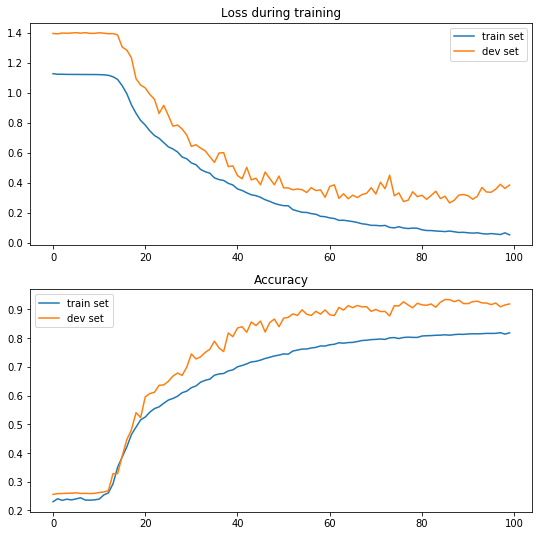

In [20]:
_, dev_acc = model.evaluate(X_dev, Y_dev, verbose=0)

# 1.1) plot loss during training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1, (9,9))
plt.subplot(211)
plt.title('Loss during training')
plt.plot(history.history['loss'], label='train set')
plt.plot(history.history['val_loss'], label='dev set')
plt.legend()

# 1.2) plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train set')
plt.plot(history.history['val_accuracy'], label='dev set')
plt.legend()

print(dev_acc)

In [21]:
Y_hat_p=model.predict(X_dev)
Y_hat=np.argmax(Y_hat_p, axis=-1)

In [22]:
Y_hat.shape

(100, 65536)

In [23]:
for i in range(Y_hat.shape[0]):
    print((i, [np.count_nonzero(Y_hat[i,:]==j) for j in range(Y_hat_p.shape[-1])], 
           [np.count_nonzero(Y_dev[i,:,:].argmax(axis=-1)==j) for j in range(Y_hat_p.shape[-1])]))

(0, [0, 0, 65423, 113], [0, 0, 65536, 0])
(1, [0, 0, 65536, 0], [0, 0, 65536, 0])
(2, [18120, 47416, 0, 0], [16310, 49226, 0, 0])
(3, [0, 62438, 0, 3098], [0, 65536, 0, 0])
(4, [0, 65473, 0, 63], [0, 65536, 0, 0])
(5, [65536, 0, 0, 0], [65536, 0, 0, 0])
(6, [65536, 0, 0, 0], [65536, 0, 0, 0])
(7, [23, 778, 64665, 70], [0, 0, 65536, 0])
(8, [0, 0, 791, 64745], [0, 0, 0, 65536])
(9, [2383, 7867, 16328, 38958], [0, 0, 0, 65536])
(10, [18120, 47416, 0, 0], [16310, 49226, 0, 0])
(11, [0, 65536, 0, 0], [0, 65536, 0, 0])
(12, [65536, 0, 0, 0], [65536, 0, 0, 0])
(13, [0, 837, 0, 64699], [0, 0, 0, 65536])
(14, [62404, 0, 0, 3132], [65536, 0, 0, 0])
(15, [0, 0, 65502, 34], [0, 0, 65536, 0])
(16, [0, 65536, 0, 0], [0, 65536, 0, 0])
(17, [0, 62438, 0, 3098], [0, 65536, 0, 0])
(18, [0, 0, 65423, 113], [0, 0, 65536, 0])
(19, [65536, 0, 0, 0], [65536, 0, 0, 0])
(20, [0, 0, 65536, 0], [0, 0, 65536, 0])
(21, [0, 65473, 0, 63], [0, 65536, 0, 0])
(22, [2383, 7867, 16328, 38958], [0, 0, 0, 65536])
(23, [5

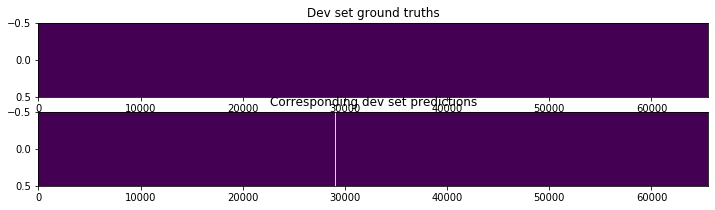

In [26]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[48:49,:].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[48:49,:].astype(int), aspect='auto')#, cmap='jet')

In [27]:
np.where(np.argmax(Y_hat_p[48,:,:], axis=-1)==3)

(array([29040, 29042, 29088, 29089, 29090, 29091, 29092, 29093, 29094,
        29095, 29096, 29097, 29099, 29100, 29101, 29102, 29104, 29105,
        29106, 29107, 29108, 29109, 29110, 29111, 29112, 29113, 29114,
        29115, 29116, 29117, 29118, 29119, 29120, 29122, 29127, 29131,
        29132, 29133, 29134, 29135, 29136, 29137, 29138, 29139, 29140,
        29149, 29150, 29151, 29152, 29153, 29154, 29155, 29156, 29158,
        29387, 29388, 29389, 29391, 29392, 29394, 29395, 29400, 29401]),)

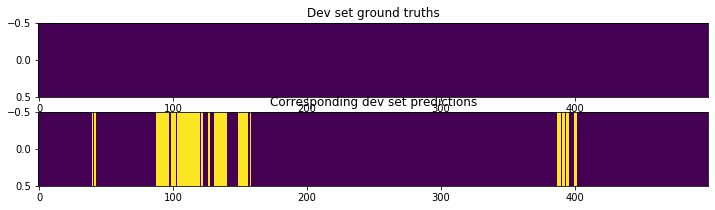

In [28]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[48:49,29000:29500].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[48:49,29000:29500].astype(int), aspect='auto')#, cmap='jet')

In [30]:
Y_hat_p[48,np.where(np.argmax(Y_hat_p[48,:,:], axis=-1)==3),:]

array([[[7.3687052e-03, 4.7687542e-01, 1.3014410e-03, 5.1445442e-01],
        [7.1993521e-03, 4.9008200e-01, 1.8654910e-03, 5.0085318e-01],
        [5.6146597e-03, 4.8125708e-01, 1.0026674e-03, 5.1212555e-01],
        [5.8690114e-03, 4.6720532e-01, 1.1260229e-03, 5.2579963e-01],
        [6.4194412e-03, 4.5242244e-01, 1.2260688e-03, 5.3993207e-01],
        [5.7026539e-03, 4.6944034e-01, 1.4531426e-03, 5.2340382e-01],
        [6.0545988e-03, 4.8332432e-01, 1.0624398e-03, 5.0955862e-01],
        [5.9698345e-03, 4.4208446e-01, 1.5739133e-03, 5.5037177e-01],
        [5.8814199e-03, 4.7893465e-01, 1.6608620e-03, 5.1352310e-01],
        [6.8885884e-03, 4.4407737e-01, 1.5018027e-03, 5.4753220e-01],
        [6.6155270e-03, 4.8793361e-01, 1.4445066e-03, 5.0400639e-01],
        [7.1595917e-03, 4.7635233e-01, 1.4797284e-03, 5.1500833e-01],
        [6.6104433e-03, 4.9198535e-01, 1.4056003e-03, 4.9999857e-01],
        [7.5436337e-03, 4.6900737e-01, 1.6317490e-03, 5.2181721e-01],
        [7.9264855e-

In [31]:
# seems like a crf-smoother (even a post-hoc one) could really help